# River Boundary Masking

## Introduction

Cold water refuges are crucial havens for fish species, offering them sanctuary and relief. These refuges are specific areas within aquatic ecosystems, such as deep pools or shaded sections, where the water remains relatively colder than the surrounding environment. With the increasing impact of climate change and its associated rising temperatures, cold water refuges serve as essential habitats for fish, providing them with a reprieve from stressful conditions and enabling their survival and reproductive success. By seeking out these refuges, fish can maintain optimal physiological functioning, evade thermal stress, and ensure the long-term sustainability of their populations.

In this section, we will use our realigned dataset to create river masks for our IR images. These masks will then be used to identify cold water refuges in the river in the next section. The segmentation model selected for use is Meta's SAM. The workflow overview of how it is utilized to create river masks is as follows:

* Create a ground truth dataset by hand using paint.net
* Create mechanism for creating point prompts for SAM
* Evaluate base model performance and generate masks

## Dataset

The first step is to build our ground truth dataset. It seems that the original processing done in 2012 included some preliminary river masks. Unfortunately, these masks are fairly poor. They also do not help with the construction of our ground truth dataset; it is easier to just manually create new masks than it is to patch up the existing masks.

The process of creating ground truth masks involves using the magic wand tool in paint.net, which selects an contiguous area of similar color based on some tolerance value. Then this area is filled with black and the rest of the image with white, and the mask can then be manually adjusted to match the river in areas where the magic wand fails to align perfectly with the river edge.

The optimal results are achieved by using RGB images layered with transparency over the IR images, as the IR images have the highest contrast between river and non-river pixels. This is because reflectance of water is lower than soil and vegetation across a wide range of the electromagnetic spectrum, including within the visible RGB portion, but the difference is most significant in the IR range.

![Quadrant Filtering](https://github.com/geo-smart/water-surf/blob/main/book/img/reflectance.png?raw=1)

The difference in reflectance then results in the contrast between the river and land pixels being larger in the IR images. This also means that while both the RGB and IR remote sensing imagery may prove relevant to the model, the IR images will be the key to accurate segmentation.

In [1]:
# !pip install -q torch transformers datasets tqdm monai

In [2]:
# !pip install -q huggingface_hub
# !huggingface-cli login

In [3]:
from datasets import load_dataset, Dataset

# TODO: not sure if this is actually Dataset type, load_dataset can return one of many types
dataset: Dataset = load_dataset("stodoran/elwha-segmentation-tiny", split="train") # type: ignore
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 114
})


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def overlayMask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def showControlPoints(coords, labels, ax, marker_size=375):
    if len(coords) == 0 or len(labels) == 0: return
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="P", s=marker_size, edgecolor="white", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="X", s=marker_size, edgecolor="white", linewidth=1.25)

def previewDatapoint(datapoint, points = None, mask = True):
    fig, axes = plt.subplots()

    axes.imshow(datapoint["image"])
    if mask: overlayMask(np.array(datapoint["label"]), axes)
    if points: showControlPoints(*points, axes) # type: ignore

    axes.axis("off")

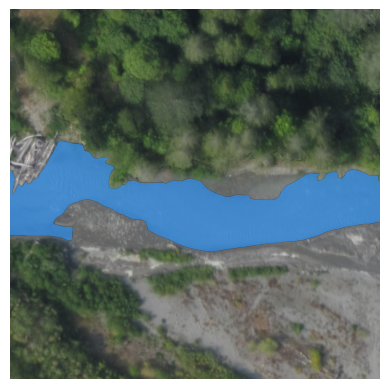

In [5]:
sample_datapoint = dataset[5]
previewDatapoint(sample_datapoint)

In [6]:
np.random.seed(0)

In [7]:
def controlPointsFromMask(mask, number, distance=0, positive=False, existing_points=[]):
  input_points = []

  def euclideanDistance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

  while len(input_points) < number:
    zero_indices = np.argwhere(mask != 0) if positive else np.argwhere(mask == 0)

    if len(zero_indices) > 0:

      found_valid = False
      while not found_valid:
        random_index = np.random.randint(0, len(zero_indices))
        row, col = zero_indices[random_index]
        new_point = [col, row]

        # Check if the new point is far enough from existing points
        too_close = False
        all_points = input_points + existing_points

        for point in all_points:
          if euclideanDistance(point, new_point) < distance:
            too_close = True
            break

        if not too_close:
          input_points.append(new_point)
          found_valid = True
          break
        else:
          zero_indices = np.delete(zero_indices, random_index, axis=0)
          if len(zero_indices) == 0:
            break
      # end while

      if not found_valid: # There are points left but none with enough distance between them.
        break

    else:
      break  # We have fewer than "number" points, but there are no valid points left.

  return np.array(input_points)

def generateInputPointsFromMask(
  number = None,
  mask = None,
  minDistance = 0,
  negativeSrcMask = None,
  numNegative = None,
  positiveSrcMask = None,
  numPositive = None,
  doPerturbation = False, # TODO: Implement this!
):
  input_points = []
  input_labels = []

  _numPositive = numPositive if numPositive is not None else number
  if _numPositive is not None:
    control_points = controlPointsFromMask(
      positiveSrcMask if positiveSrcMask is not None else mask,
      _numPositive,
      distance=minDistance,
      positive=True
    )
    input_points.extend(control_points)
    input_labels.extend([1] * len(control_points))

  _numNegative = numNegative if numNegative is not None else number
  if _numNegative is not None:
    control_points = controlPointsFromMask(
      negativeSrcMask if negativeSrcMask is not None else mask,
      _numNegative,
      distance=minDistance,
      existing_points=input_points
    )
    input_points.extend(control_points)
    input_labels.extend([0] * len(control_points))

  input_points = np.array(input_points)
  input_labels = np.array(input_labels)

  return input_points, input_labels

TODO: should we erode the mask before picking training control points? perhaps just erode less than inference time?

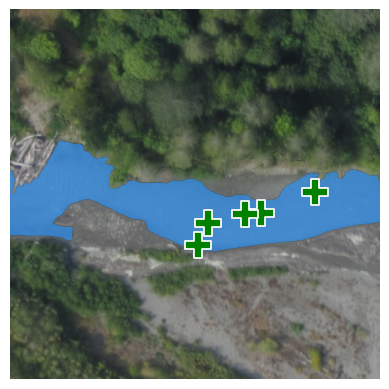

In [8]:
points = generateInputPointsFromMask(numPositive=5, mask=np.array(sample_datapoint["label"]))
previewDatapoint(sample_datapoint, points)

In [9]:
from torch.utils.data import Dataset
import cv2

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    datapoint = self.dataset[idx]
    input_image = cv2.resize(np.array(datapoint["image"]), (256, 256))
    ground_truth_mask = cv2.resize(np.array(datapoint["label"]), (256, 256))

    # Get control points prompt.
    input_points, input_labels = generateInputPointsFromMask(numPositive=5, mask=ground_truth_mask)
    input_points = input_points.astype(float).tolist()
    input_labels = input_labels.tolist()
    input_labels = [[x] for x in input_labels]

    # Prepare the image and prompt for the model.
    inputs = self.processor(input_image, input_points=input_points, input_labels=input_labels, return_tensors="pt")

    # Remove batch dimension which the processor adds by default.
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    # inputs["input_points"] = inputs["input_points"].squeeze(1)
    inputs["input_labels"] = inputs["input_labels"].squeeze(1)

    # Add ground truth segmentation.
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [10]:
from transformers import SamProcessor
from torch.utils.data import DataLoader

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [11]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [12]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([5, 1, 2])
input_labels torch.Size([5, 1])
ground_truth_mask (256, 256)


In [13]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_points torch.Size([2, 5, 1, 2])
input_labels torch.Size([2, 5, 1])
ground_truth_mask torch.Size([2, 256, 256])


In [14]:
from transformers import SamModel, PreTrainedModel
from torch.optim import Adam
from typing import Any
import monai

model: Any = SamModel.from_pretrained("facebook/sam-vit-base") # type: ignore
# model = SamModel.from_pretrained("facebook/sam-vit-huge")

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0) # TODO: SAM for polyp segmentation used AdamW
lossFn = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction="mean")

In [15]:
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [16]:
!mkdir checkpoints
checkpoint_path = "./checkpoints/best_model.pth"
load_checkpoint = False

A subdirectory or file checkpoints already exists.


In [17]:
import torch

num_epochs = 1000
save_every = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

if load_checkpoint:
  checkpoint = torch.load(checkpoint_path)

  model.load_state_dict(checkpoint["model_state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
  epoch = checkpoint["epoch"] + 1  # Start from the next epoch

  print(f"Model checkpoint loaded from: {checkpoint_path}")
  print(f"Resuming training from epoch: {epoch}")
else:
  epoch = 0

In [ ]:
from tqdm import tqdm
from statistics import mean

for epoch in range(num_epochs):
  epoch_losses = []

  for batch in tqdm(train_dataloader):
    # Forward Pass
    prompt_output = model.prompt_encoder(
      input_points=batch["input_points"].to(device),
      input_labels=batch["input_labels"].to(device),
      input_boxes=None, input_masks=None,
    )

    outputs = model(
      pixel_values=batch["pixel_values"].to(device),
      input_points=batch["input_points"].to(device),
      input_labels=batch["input_labels"].to(device),
      multimask_output=False,
    ) # type: ignore

    # Compute Loss
    predicted_masks = outputs.pred_masks.squeeze((1, 2))
    ground_truth_masks = batch["ground_truth_mask"].float().to(device)
    loss = lossFn(predicted_masks[:, 0], ground_truth_masks)

    # Backward Pass (compute gradients of parameters w.r.t. loss)
    optimizer.zero_grad()
    loss.backward()

    # Optimize Step
    optimizer.step()
    epoch_losses.append(loss.item())
  # END FOR

  if epoch % save_every == 0:
    print("Saving checkpoint...")
    checkpoint = {
      "epoch": epoch,
      "model_state_dict": model.state_dict(),
      "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path)
  # END IF

  print(f"Epoch: {epoch}")
  print(f"Mean loss: {mean(epoch_losses)}")

In [19]:
model.eval()
batch = next(iter(train_dataloader))

In [43]:
with torch.no_grad(): # Forward Pass
  prompt_output = model.prompt_encoder(
    input_points=batch["input_points"].to(device),
    input_labels=batch["input_labels"].to(device),
    input_boxes=None, input_masks=None,
  )

  outputs = model(
    pixel_values=batch["pixel_values"].to(device),
    input_points=batch["input_points"].to(device),
    input_labels=batch["input_labels"].to(device),
    multimask_output=False,
  ) # type: ignore

  # Compute Loss
  predicted_masks = outputs.pred_masks.squeeze((1, 2))
  ground_truth_masks = batch["ground_truth_mask"].float().to(device)
  loss = lossFn(predicted_masks[:, 0], ground_truth_masks)

In [50]:
torch.min(predicted_masks[0,0]), torch.max(predicted_masks[0,0])

(tensor(-4.2787), tensor(7.6498))

In [48]:
def visuallyEvaluateModel(model: SamModel, dataloader: DataLoader, displayCount: int):
  # model.eval()
  iterCount = 0

  for batch in tqdm(dataloader, desc="Eval"):
    # Forward Pass
    with torch.no_grad():
      outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        input_points=batch["input_points"].to(device),
        input_labels=batch["input_labels"].to(device),
        multimask_output=False,
      ) # type: ignore

    # Compute Loss
    predicted_masks = outputs.pred_masks.squeeze((1, 2))
    ground_truth_masks = batch["ground_truth_mask"].float().to(device)
    loss = lossFn(predicted_masks[:, 0], ground_truth_masks)

    for batch_item in range(predicted_masks.shape[0]):
      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
      mask = predicted_masks[batch_item, 0].cpu()
      overlayMask(mask, axes[0])
      axes[1].imshow(batch["ground_truth_mask"][batch_item])

    if iterCount >= displayCount:
      break
    iterCount += 1
  # END FOR

Eval:   0%|          | 0/57 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Eval:   2%|▏         | 1/57 [00:18<17:36, 18.86s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Eval:   4%|▎         | 2/57 [00:31<14:08, 15.43s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Eval:   5%|▌         | 3/57 [00:45<13:17, 14.76s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the val

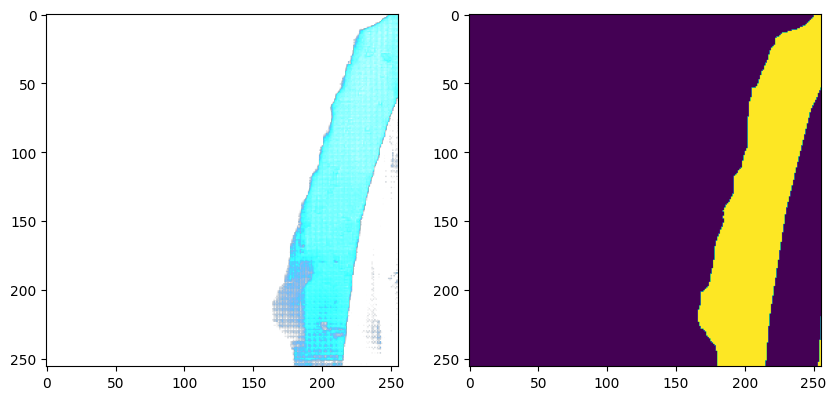

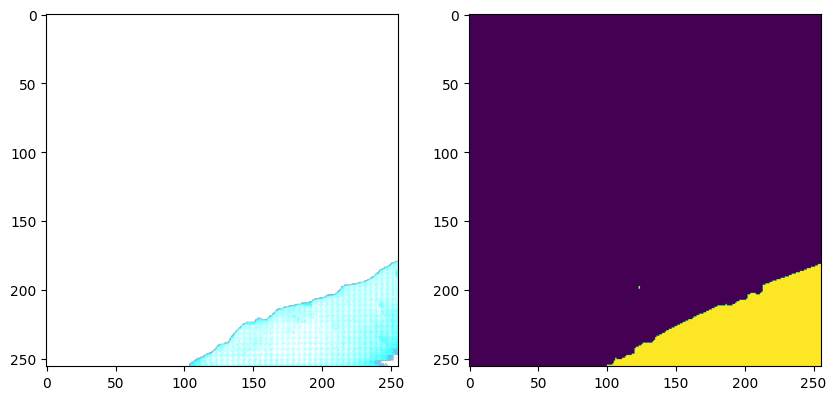

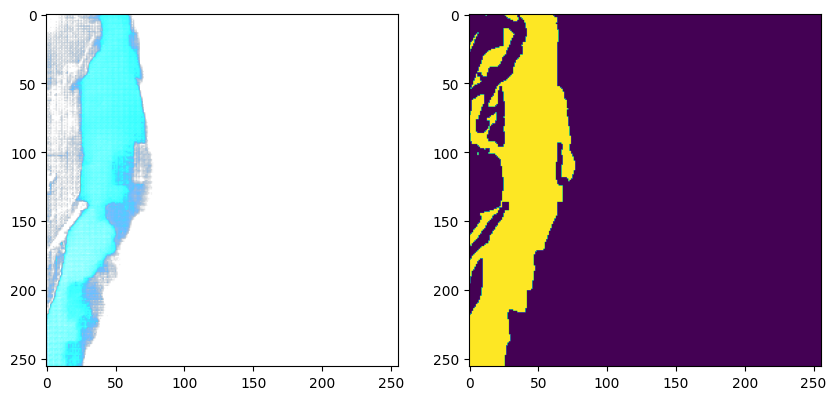

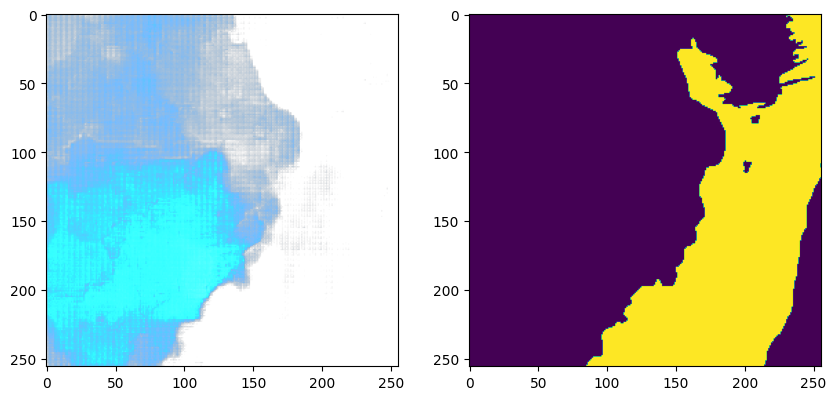

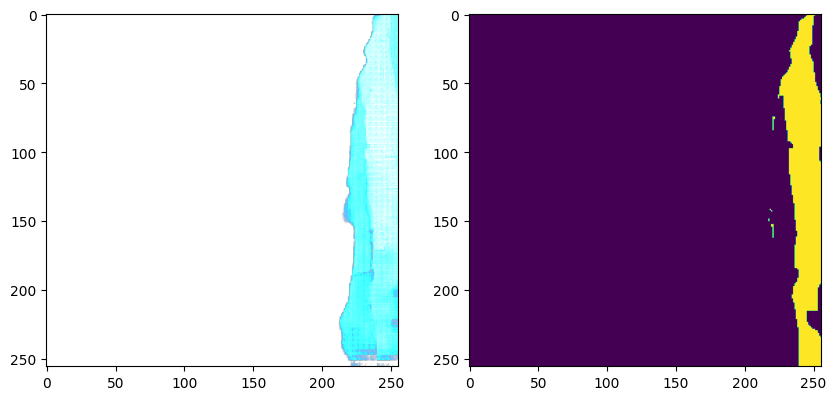

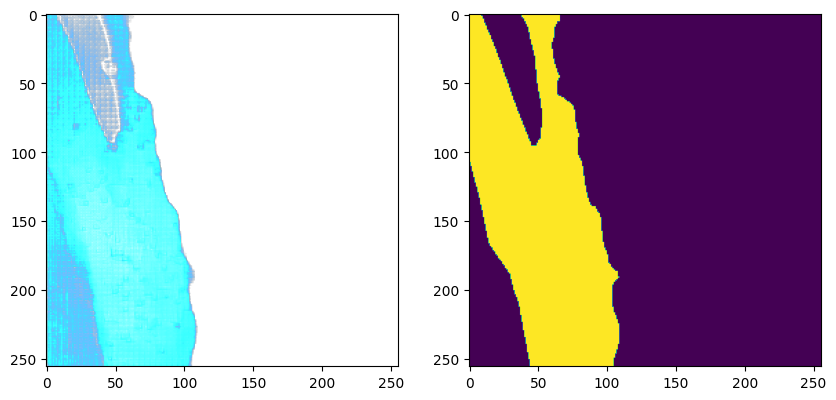

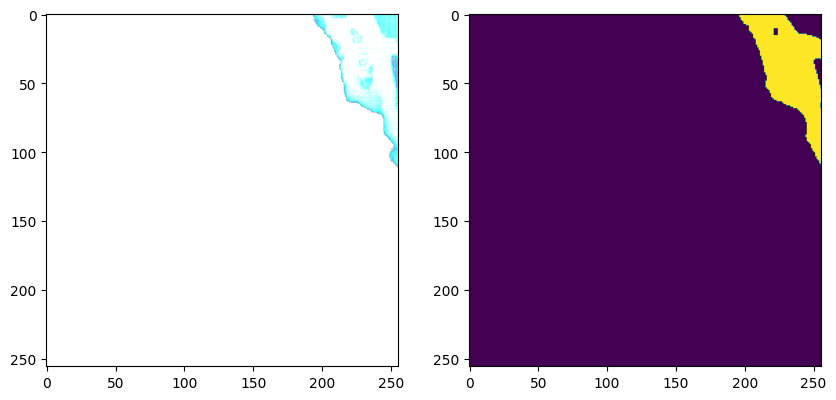

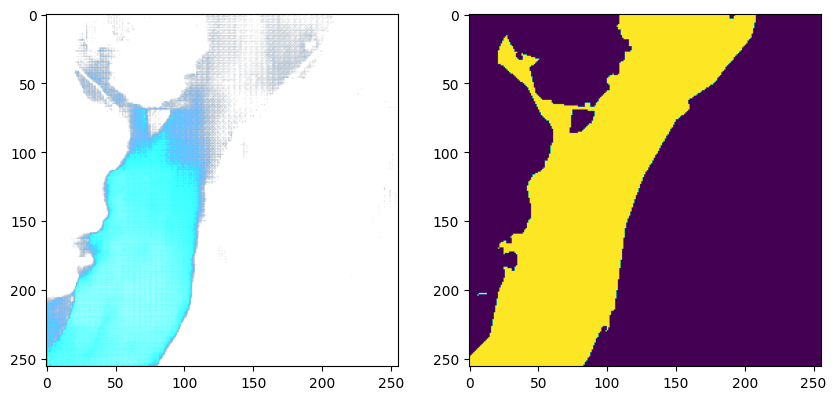

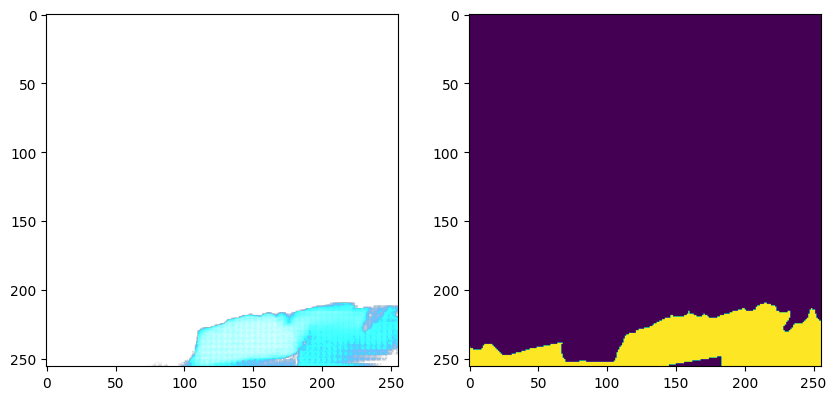

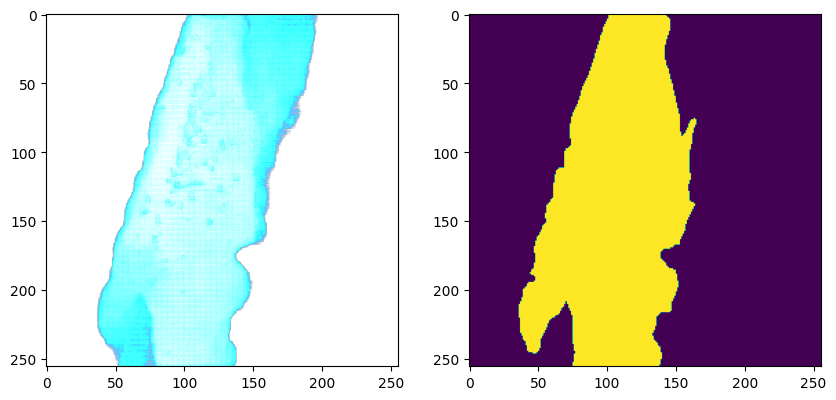

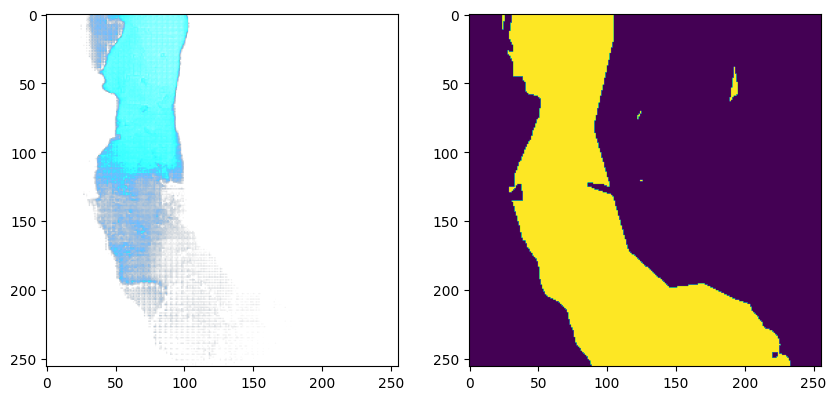

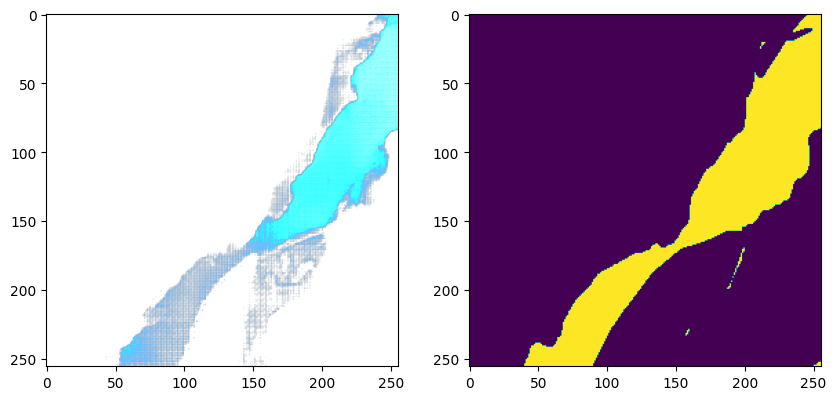

In [49]:
visuallyEvaluateModel(model, train_dataloader, 5)